# Setup

## Mount Drive

In [84]:
from google.colab import drive
drive.mount('/content/drive')
raw_data_location='/content/drive/My Drive/Capstone/Data/Raw/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## pip install

In [85]:
pip install contractions scikeras imblearn

## Libraries

In [86]:
# Generic libraries
import pandas as pd
import numpy as np
import tensorflow as tf

# Sklearn library
from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks, RandomUnderSampler

# Charting library
import matplotlib.pyplot as plt
import seaborn as sns

# NN libraries

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import SimpleRNN,Embedding,LSTM,Dense,Dropout,Input, concatenate,Flatten, BatchNormalization
from keras.optimizers import Adam
# from keras.models import Model
# from keras.layers import Input, concatenate
from scikeras.wrappers import KerasClassifier
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import contractions
import nltk
import gensim
from gensim.models import Word2Vec, KeyedVectors
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

import warnings
warnings.filterwarnings('ignore')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Import Word2Vec pre trained embedding

In [87]:
word_vectors = KeyedVectors.load_word2vec_format(raw_data_location+"/GoogleNews-vectors-negative300.bin.gz", binary=True)

# Data preprocessing

## Data import

In [88]:
df=pd.read_excel(raw_data_location + "/Data Set - industrial_safety_and_health_database_with_accidents_description.xlsx",usecols=lambda column: column != 'Unnamed: 0')

Data set
  In this dataset, the information about accidents in 12 manufacturing plants in 3 countries are given by a brazilian company. We need to use this dataset to understand why accidents occur, and discover clues to reduce tragedic accidents.

Dataset columns are below:
    
*   **Data** : timestamp or time/date information
*   **Countries** : which country the accident occurred
*   **Local** : the city where the manufacturing plant is located
*   **Industry sector** : which sector the plant belongs to
*   **Accident level **: from I to V, it registers how severe was the accident (I means not severe but V means very severe).
*   **Industry sector** : which sector the plant belongs to
*   **Potential Accident Level** : Depending on the Accident Level, the database also registers how severe the accident could have been (due to other factors involved in the accident)  
*   **Genre** : if the person is male of female
*   **Employee or Third Party **: if the injured person is an employee or a third party
*  **Critical Risk** : some description of the risk involved in the accident
*  **Description** : Detailed description of how the accident happened
    

## Basic checks

In [89]:
print("1.Shape of the data")
print("_______")
print("The no. of rows in the data are",df.shape[0])
print("The no. of columns in the data are",df.shape[1])
print("=======")

print("2.Data types")
print("_______")
print(df.info())
print("=======")

print("3.Columns")
print("_______")
print(df.columns)
print("=======")
# Two columns are mislabeled
# Data -> Date
# Genre -> Gender

1.Shape of the data
_______
The no. of rows in the data are 425
The no. of columns in the data are 10
2.Data types
_______
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 425 entries, 0 to 424
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   Data                      425 non-null    datetime64[ns]
 1   Countries                 425 non-null    object        
 2   Local                     425 non-null    object        
 3   Industry Sector           425 non-null    object        
 4   Accident Level            425 non-null    object        
 5   Potential Accident Level  425 non-null    object        
 6   Genre                     425 non-null    object        
 7   Employee or Third Party   425 non-null    object        
 8   Critical Risk             425 non-null    object        
 9   Description               425 non-null    object        
dtypes: datetime64[ns](1), o

## Data Cleansing

In [90]:
#Removing the duplicated records
df_nodup= df.drop_duplicates(keep='first')
df_nodup.reset_index(drop=True,inplace=True)
df_nodup = df_nodup.rename(columns={'Data': 'Date', 'Genre': 'Gender'})

# Target encoding
target_encoder = LabelEncoder()
df_nodup['encoded_accident'] = target_encoder.fit_transform(df_nodup['Accident Level'])

#Create time related variables
df_nodup['Date'] = pd.to_datetime(df_nodup['Date'])
df_nodup['Year'] = df_nodup['Date'].dt.year
df_nodup['Month'] = df_nodup['Date'].dt.month
df_nodup['Day'] = df_nodup['Date'].dt.day
df_nodup['Weekday'] = df_nodup['Date'].dt.weekday

# one hot encoding
onehotvars=['Countries','Local','Industry Sector','Gender','Employee or Third Party','Critical Risk','Year','Month','Day','Weekday']
df_nodup = pd.get_dummies(df_nodup,columns=onehotvars)

#cleansing description
lemmatizer = WordNetLemmatizer()
cleansed_description=[]
for i in range(df_nodup.shape[0]):
  expanded_description = contractions.fix(df_nodup['Description'].iloc[i]).lower()
  words = word_tokenize(expanded_description)
  lemmatized_words = [lemmatizer.lemmatize(word,pos='v') for word in words]
  cleansed_desc = ' '.join(lemmatized_words)
  cleansed_description.append(cleansed_desc)
df_nodup['cleansed_description'] = cleansed_description

In [91]:
print("There are",df_nodup.duplicated(keep=False,subset=["Description"]).sum(),"records with same description")
df_nodup[df_nodup.duplicated(keep=False,subset=["Description"])]

There are 14 records with same description


,Date,Accident Level,Potential Accident Level,Description,encoded_accident,Countries_Country_01,Countries_Country_02,Countries_Country_03,Local_Local_01,Local_Local_02,...,Day_30,Day_31,Weekday_0,Weekday_1,Weekday_2,Weekday_3,Weekday_4,Weekday_5,Weekday_6,cleansed_description
37,2016-02-24,I,V,When starting the activity of removing a coil ...,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,when start the activity of remove a coil of el...
38,2016-02-24,I,V,When starting the activity of removing a coil ...,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,when start the activity of remove a coil of el...
129,2016-05-26,I,I,"In the geological reconnaissance activity, in ...",0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,"in the geological reconnaissance activity , in..."
130,2016-05-26,I,I,"In the geological reconnaissance activity, in ...",0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,"in the geological reconnaissance activity , in..."
142,2016-06-08,I,I,Project of Vazante that carried out sediment c...,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,project of vazante that carry out sediment col...
143,2016-06-08,I,I,Project of Vazante that carried out sediment c...,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,project of vazante that carry out sediment col...
165,2016-07-07,IV,V,At moments when the MAPERU truck of plate F1T ...,3,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,at moments when the maperu truck of plate f1t ...
166,2016-07-07,I,IV,At moments when the MAPERU truck of plate F1T ...,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,at moments when the maperu truck of plate f1t ...
260,2016-12-01,I,IV,During the activity of chuteo of ore in hopper...,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,during the activity of chuteo of ore in hopper...
261,2016-12-01,I,IV,During the activity of chuteo of ore in hopper...,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,during the activity of chuteo of ore in hopper...


In [92]:
print(df_nodup.shape)
indices_to_drop = [166, 382]
df_nodup = df_nodup.drop(indices_to_drop, axis=0)
df_nodup.reset_index(drop=True,inplace=True)
print(df_nodup.shape)

(418, 114)
(416, 114)


# Modeling data preparation

## Train Test split

In [93]:
vars_to_drop=['Date','Description','encoded_accident','Accident Level', 'Potential Accident Level']
x=df_nodup.drop(vars_to_drop,axis=1)
y=df_nodup['encoded_accident']
test_split=0.2
train_x,test_x,train_y,test_y=  train_test_split(x,y,test_size=test_split,random_state=1,stratify=y)
# Reset the index of both DataFrames to ensure alignment
train_y_reset = train_y.reset_index(drop=True)
train_x_reset = train_x.reset_index(drop=True)
print("Train value counts")
print(round((train_y.value_counts(normalize=True))*100),2)
print("***************")
print("Test value counts")
print(round((test_y.value_counts(normalize=True))*100),2)


Train value counts
0    74.0
1     9.0
2     8.0
3     7.0
4     2.0
Name: encoded_accident, dtype: float64 2
***************
Test value counts
0    74.0
1    10.0
3     7.0
2     7.0
4     2.0
Name: encoded_accident, dtype: float64 2


## Vectorization

Mean length of description in the data: 359
90th percentile length of description in the data: 600
max length of descritption in the data: 992


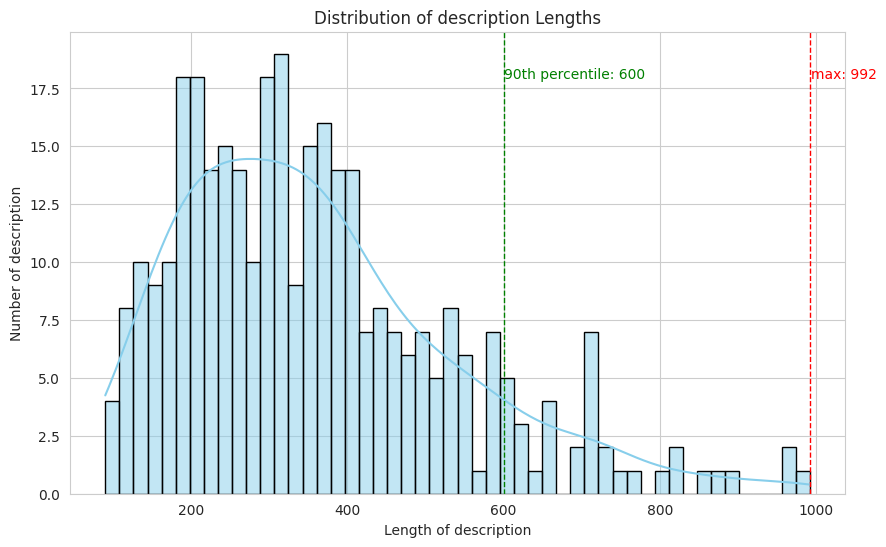

array([  13,   97,    1,   98,  162,    2,    1,  622,   75,   81,    1,
         19,   47,   12,   20,   18,  105,  200,    1,   37, 1355,    2,
          1,  153,  127,    7,  407,   27,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,   

In [94]:
# Initialize the Tokenizer:
# Tokenizer is a class from Keras used to convert text into sequences of integers, where each integer
# represents a specific word. This is necessary for neural networks to process textual data.
tokenizer = Tokenizer()

# Fit the tokenizer on the training data:
# This step updates the tokenizer's internal vocabulary based on the text it sees in the training data.
tokenizer.fit_on_texts(train_x_reset['cleansed_description'])

# Check the length of each description and append it to a list
lengths_all_description = []
for description in train_x_reset['cleansed_description']:
    length = len(description)
    lengths_all_description.append(length)

# Explore the length among all headlines
mean_len=round(np.mean(lengths_all_description))
perc90_len = round(np.percentile(lengths_all_description,90))
max_len=max(lengths_all_description)
print("Mean length of description in the data:", mean_len)
print("90th percentile length of description in the data:", perc90_len)
print("max length of descritption in the data:", max_len)

max_sequence_length=mean_len

# Plotting the histogram using Seaborn
plt.figure(figsize=(10, 6))
sns.histplot(lengths_all_description, bins=50, kde=True, color='skyblue', edgecolor='black')
plt.title('Distribution of description Lengths')
plt.xlabel('Length of description')
plt.ylabel('Number of description')
plt.axvline(perc90_len, color='green', linestyle='dashed', linewidth=1)  # Mark the 90th percentile
plt.text(perc90_len + 1, plt.ylim()[1] * 0.9, f'90th percentile: {perc90_len}', color = 'green')
plt.axvline(max_len, color='red', linestyle='dashed', linewidth=1)  # Mark the max
plt.text(max_len + 1, plt.ylim()[1] * 0.9, f'max: {max_len}', color = 'red')

plt.show()
# Convert text to sequences of integers for both training and testing data:
tokenized_sequence_train = tokenizer.texts_to_sequences(train_x_reset['cleansed_description'].tolist())
tokenized_sequence_test = tokenizer.texts_to_sequences(test_x['cleansed_description'].tolist())

# Pad the sequences:
# This ensures all sequences in a list have the same length by padding them with zeros (by default) where necessary.
padded_sequence_train = pad_sequences(tokenized_sequence_train, maxlen=max_sequence_length,padding='post')
padded_sequence_test = pad_sequences(tokenized_sequence_test, maxlen=max_sequence_length,padding='post')
padded_sequence_train[0]

## Categorical data

In [95]:
train_categorical_data=train_x_reset.drop(['cleansed_description'],axis=1)
test_categorical_data=test_x.drop(['cleansed_description'],axis=1)

## Y variable encoding

In [96]:
y_train_encoded=to_categorical(train_y)
y_test_encoded=to_categorical(test_y)

## Over and Undersampling

In [97]:
print(train_y.value_counts())

0    246
1     31
2     25
3     24
4      6
Name: encoded_accident, dtype: int64


In [98]:
smote = SMOTE()
sampling_strategy = {0: 200, 1: 31, 2: 24,3:24,4:6}
rus = RandomUnderSampler(sampling_strategy=sampling_strategy,random_state=42)

### On text data only

In [99]:
x_resampled, y_resampled = rus.fit_resample(padded_sequence_train, train_y_reset)
x_resampled, y_resampled = smote.fit_resample(x_resampled, y_resampled)
# x_resampled, y_resampled = smote.fit_resample(padded_sequence_train, train_y_reset)
y_train_encoded_resampled=to_categorical(y_resampled)
print(y_resampled.value_counts())

0    200
1    200
2    200
3    200
4    200
Name: encoded_accident, dtype: int64


### Text and categorical data both

In [100]:
x_train_combined = np.hstack((padded_sequence_train, train_categorical_data))

In [101]:
# Create an instance of the SMOTE class and random undersampler class
x_resampled_co, y_resampled_co = rus.fit_resample(x_train_combined, train_y_reset)
x_resampled_co, y_resampled_co = smote.fit_resample(x_resampled_co, y_resampled_co)
y_resampled_encoded = to_categorical(y_resampled_co)

# Separate the resampled data back into text and categorical features
max_text_length = max_sequence_length
num_categorical_features = train_categorical_data.shape[1]

padded_sequence_resampled = x_resampled_co[:, :max_text_length]
categorical_data_resampled = x_resampled_co[:, max_text_length:max_text_length + num_categorical_features]

# Model building

## Model Hyperparameters

### Class weights

In [102]:
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(train_y), y=train_y)
class_weights_dict = dict(enumerate(class_weights))

### Embedding size

In [103]:
embedding_size=10

### Pre trained word embedding - Word2Vec

In [104]:
embedding_dim = 300  # Dimension of the Google News Word2Vec vectors
vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in tokenizer.word_index.items():
    if word in word_vectors.key_to_index:
        # Words not found in the embedding index will be all zeros.
        embedding_matrix[i] = word_vectors[word]

## ANN with cleansed description only

In [105]:
import random as python_random
def reset_random_seeds(seed_value=42):
   python_random.seed(seed_value)
   np.random.seed(seed_value)
   tf.random.set_seed(seed_value)

In [106]:
tf.keras.backend.clear_session()
reset_random_seeds()
ann_model=Sequential()
ann_model.add(Dense(64,activation='relu',input_shape=(max_sequence_length,)))
ann_model.add(BatchNormalization())
ann_model.add(Dense(64,activation='relu'))
ann_model.add(BatchNormalization())
ann_model.add(Dense(64,activation='relu'))
ann_model.add(BatchNormalization())
ann_model.add(Dense(5,activation='softmax'))
ann_model.compile(optimizer=Adam(learning_rate=0.01),loss='categorical_crossentropy',metrics=['accuracy'])
ann_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                23040     
                                                                 
 batch_normalization (Batch  (None, 64)                256       
 Normalization)                                                  
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 batch_normalization_1 (Bat  (None, 64)                256       
 chNormalization)                                                
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 batch_normalization_2 (Bat  (None, 64)                2

In [107]:
ann_model.fit(padded_sequence_train,y_train_encoded, epochs=20, batch_size=16,class_weight=class_weights_dict, validation_split=0.3)

Epoch 1/20
15/15 [==============================] - 2s 23ms/step - loss: 1.9240 - accuracy: 0.1853 - val_loss: 3.7112 - val_accuracy: 0.5300
Epoch 2/20
15/15 [==============================] - 0s 9ms/step - loss: 1.0595 - accuracy: 0.3362 - val_loss: 3.5471 - val_accuracy: 0.3700
Epoch 3/20
15/15 [==============================] - 0s 16ms/step - loss: 0.6583 - accuracy: 0.4181 - val_loss: 3.1666 - val_accuracy: 0.1700
Epoch 4/20
15/15 [==============================] - 1s 43ms/step - loss: 0.4789 - accuracy: 0.5603 - val_loss: 2.3515 - val_accuracy: 0.3100
Epoch 5/20
15/15 [==============================] - 0s 23ms/step - loss: 0.2973 - accuracy: 0.7026 - val_loss: 2.6563 - val_accuracy: 0.3700
Epoch 6/20
15/15 [==============================] - 0s 22ms/step - loss: 0.2120 - accuracy: 0.8017 - val_loss: 2.3741 - val_accuracy: 0.4500
Epoch 7/20
15/15 [==============================] - 0s 28ms/step - loss: 0.1805 - accuracy: 0.8879 - val_loss: 2.2007 - val_accuracy: 0.4900
Epoch 8/20
15/

In [108]:
# Predict the class probabilities for the test set using the trained model.
pred_test_ann = ann_model.predict(padded_sequence_test)

# Convert the predicted probabilities into class labels.
# The 'argmax' function is used here to select the class with the highest probability as the predicted class.
y_pred_classes_ann = pred_test_ann.argmax(axis=1)

# Generate a classification report by comparing the true class labels of the test set ('test_y')
# with the predicted class labels ('y_pred_classes').
report_ann = classification_report(test_y, y_pred_classes_ann)

# Print the classification report to review the model's performance on the test set.
print(report_ann)

3/3 [==============================] - 0s 6ms/step
              precision    recall  f1-score   support

           0       0.74      0.73      0.73        62
           1       0.25      0.25      0.25         8
           2       0.00      0.00      0.00         6
           3       0.17      0.17      0.17         6
           4       0.00      0.00      0.00         2

    accuracy                           0.57        84
   macro avg       0.23      0.23      0.23        84
weighted avg       0.58      0.57      0.58        84



## ANN with cleansed description only + resampled Train data

In [109]:
tf.keras.backend.clear_session()
reset_random_seeds()
ann_model_resampled=Sequential()
ann_model_resampled.add(Dense(64,activation='relu',input_shape=(max_sequence_length,)))
ann_model_resampled.add(BatchNormalization())
ann_model_resampled.add(Dense(64,activation='relu'))
ann_model_resampled.add(BatchNormalization())
ann_model_resampled.add(Dense(64,activation='relu'))
ann_model_resampled.add(BatchNormalization())
ann_model_resampled.add(Dense(5,activation='softmax'))
ann_model_resampled.compile(optimizer=Adam(learning_rate=0.01),loss='categorical_crossentropy',metrics=['accuracy'])
ann_model_resampled.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                23040     
                                                                 
 batch_normalization (Batch  (None, 64)                256       
 Normalization)                                                  
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 batch_normalization_1 (Bat  (None, 64)                256       
 chNormalization)                                                
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 batch_normalization_2 (Bat  (None, 64)                2

In [110]:
ann_model_resampled.fit(x_resampled,y_train_encoded_resampled, epochs=5, batch_size=16, validation_split=0.3)

Epoch 1/5
44/44 [==============================] - 4s 19ms/step - loss: 1.0537 - accuracy: 0.6171 - val_loss: 3.2202 - val_accuracy: 0.3333
Epoch 2/5
44/44 [==============================] - 0s 11ms/step - loss: 0.4718 - accuracy: 0.8543 - val_loss: 0.7938 - val_accuracy: 0.5767
Epoch 3/5
44/44 [==============================] - 0s 11ms/step - loss: 0.3406 - accuracy: 0.8743 - val_loss: 1.2731 - val_accuracy: 0.4133
Epoch 4/5
44/44 [==============================] - 1s 15ms/step - loss: 0.2791 - accuracy: 0.9029 - val_loss: 0.8263 - val_accuracy: 0.6167
Epoch 5/5
44/44 [==============================] - 1s 27ms/step - loss: 0.2485 - accuracy: 0.8971 - val_loss: 0.6766 - val_accuracy: 0.8333


In [111]:
pred_test_ann_resampled = ann_model_resampled.predict(padded_sequence_test)
y_pred_classes_ann_resampled = pred_test_ann_resampled.argmax(axis=1)
report_ann_resampled = classification_report(test_y, y_pred_classes_ann_resampled)
print(report_ann_resampled)

3/3 [==============================] - 0s 4ms/step
              precision    recall  f1-score   support

           0       0.71      0.55      0.62        62
           1       0.09      0.25      0.13         8
           2       0.00      0.00      0.00         6
           3       0.12      0.17      0.14         6
           4       0.00      0.00      0.00         2

    accuracy                           0.44        84
   macro avg       0.18      0.19      0.18        84
weighted avg       0.54      0.44      0.48        84



## Simple RNN with cleansed description only

In [112]:
tf.keras.backend.clear_session()
reset_random_seeds()
rnn_model = Sequential()
rnn_model.add(SimpleRNN(32,input_shape=(max_sequence_length,1),return_sequences=False))
rnn_model.add(BatchNormalization())
rnn_model.add(Dense(64, activation='relu'))
rnn_model.add(BatchNormalization())
# rnn_model.add(Dense(32, activation='relu'))
# rnn_model.add(BatchNormalization())
rnn_model.add(Dense(5,activation='softmax'))
rnn_model.compile(optimizer=Adam(learning_rate=0.1),loss='categorical_crossentropy',metrics=['accuracy'])
rnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 32)                1088      
                                                                 
 batch_normalization (Batch  (None, 32)                128       
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 64)                2112      
                                                                 
 batch_normalization_1 (Bat  (None, 64)                256       
 chNormalization)                                                
                                                                 
 dense_1 (Dense)             (None, 5)                 325       
                                                                 
Total params: 3909 (15.27 KB)
Trainable params: 3717 (14

In [113]:
rnn_model.fit(padded_sequence_train,y_train_encoded, epochs=10, batch_size=16, validation_split=0.3)

Epoch 1/10
15/15 [==============================] - 9s 193ms/step - loss: 1.8101 - accuracy: 0.5345 - val_loss: 5.2328 - val_accuracy: 0.0700
Epoch 2/10
15/15 [==============================] - 2s 164ms/step - loss: 1.2356 - accuracy: 0.6724 - val_loss: 2.0447 - val_accuracy: 0.7000
Epoch 3/10
15/15 [==============================] - 3s 186ms/step - loss: 1.3400 - accuracy: 0.6897 - val_loss: 1.2572 - val_accuracy: 0.7200
Epoch 4/10
15/15 [==============================] - 3s 204ms/step - loss: 1.0697 - accuracy: 0.7414 - val_loss: 1.3213 - val_accuracy: 0.7100
Epoch 5/10
15/15 [==============================] - 2s 152ms/step - loss: 0.9259 - accuracy: 0.7371 - val_loss: 1.1324 - val_accuracy: 0.7200
Epoch 6/10
15/15 [==============================] - 2s 151ms/step - loss: 0.9124 - accuracy: 0.7500 - val_loss: 1.2573 - val_accuracy: 0.7200
Epoch 7/10
15/15 [==============================] - 3s 175ms/step - loss: 0.8921 - accuracy: 0.7500 - val_loss: 1.1119 - val_accuracy: 0.7200
Epoch 

In [114]:
pred_test_rnn=rnn_model.predict(padded_sequence_test)
y_pred_classes_rnn=pred_test_rnn.argmax(axis=1)
report_rnn=classification_report(test_y,y_pred_classes_rnn)
print(report_rnn)

3/3 [==============================] - 0s 16ms/step
              precision    recall  f1-score   support

           0       0.74      1.00      0.85        62
           1       0.00      0.00      0.00         8
           2       0.00      0.00      0.00         6
           3       0.00      0.00      0.00         6
           4       0.00      0.00      0.00         2

    accuracy                           0.74        84
   macro avg       0.15      0.20      0.17        84
weighted avg       0.54      0.74      0.63        84



## Simple RNN with cleansed description only + resampled

In [115]:
reset_random_seeds()
tf.keras.backend.clear_session()
rnn_model_resampled = Sequential()
rnn_model_resampled.add(SimpleRNN(32,input_shape=(max_sequence_length,1),return_sequences=False))
rnn_model_resampled.add(BatchNormalization())
rnn_model_resampled.add(Dense(64, activation='relu'))
rnn_model_resampled.add(BatchNormalization())
rnn_model_resampled.add(Dense(32, activation='relu'))
rnn_model_resampled.add(Dense(5,activation='softmax'))
rnn_model_resampled.compile(optimizer=Adam(learning_rate=0.0001),loss='categorical_crossentropy',metrics=['accuracy'])
rnn_model_resampled.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 32)                1088      
                                                                 
 batch_normalization (Batch  (None, 32)                128       
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 64)                2112      
                                                                 
 batch_normalization_1 (Bat  (None, 64)                256       
 chNormalization)                                                
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 5)                 1

In [116]:
rnn_model_resampled.fit(x_resampled,y_train_encoded_resampled, epochs=10, batch_size=16, validation_split=0.3)

Epoch 1/10
44/44 [==============================] - 6s 92ms/step - loss: 1.7086 - accuracy: 0.2243 - val_loss: 1.6514 - val_accuracy: 0.2933
Epoch 2/10
44/44 [==============================] - 3s 75ms/step - loss: 1.5741 - accuracy: 0.2757 - val_loss: 1.6649 - val_accuracy: 0.3267
Epoch 3/10
44/44 [==============================] - 2s 57ms/step - loss: 1.4568 - accuracy: 0.3557 - val_loss: 1.6872 - val_accuracy: 0.3233
Epoch 4/10
44/44 [==============================] - 3s 58ms/step - loss: 1.4140 - accuracy: 0.3700 - val_loss: 1.7594 - val_accuracy: 0.3100
Epoch 5/10
44/44 [==============================] - 3s 58ms/step - loss: 1.3698 - accuracy: 0.3686 - val_loss: 1.8287 - val_accuracy: 0.2933
Epoch 6/10
44/44 [==============================] - 5s 105ms/step - loss: 1.3539 - accuracy: 0.3986 - val_loss: 1.9000 - val_accuracy: 0.2567
Epoch 7/10
44/44 [==============================] - 3s 57ms/step - loss: 1.3423 - accuracy: 0.4014 - val_loss: 2.0107 - val_accuracy: 0.2267
Epoch 8/10
4

In [117]:
pred_test_rnn_resampled=rnn_model_resampled.predict(padded_sequence_test)
y_pred_classes_rnn_resampled=pred_test_rnn_resampled.argmax(axis=1)
report_rnn_resampled=classification_report(test_y,y_pred_classes_rnn_resampled)
print(report_rnn_resampled)

3/3 [==============================] - 0s 18ms/step
              precision    recall  f1-score   support

           0       0.86      0.10      0.17        62
           1       0.09      0.50      0.16         8
           2       0.08      0.17      0.11         6
           3       0.05      0.17      0.07         6
           4       0.00      0.00      0.00         2

    accuracy                           0.14        84
   macro avg       0.21      0.19      0.10        84
weighted avg       0.65      0.14      0.16        84



## Simple RNN with cleansed description + resampled data + Embedding layer


In [118]:
reset_random_seeds()
tf.keras.backend.clear_session()
rnn_model_embedding = Sequential()
rnn_model_embedding.add(Embedding(input_dim=len(tokenizer.word_index)+1,
                    output_dim = embedding_size,
                    input_length = max_sequence_length))
rnn_model_embedding.add(SimpleRNN(16,input_shape=(max_sequence_length,1),return_sequences=False))
rnn_model_embedding.add(BatchNormalization())
rnn_model_embedding.add(Dense(64, activation='relu'))
rnn_model_embedding.add(BatchNormalization())
rnn_model_embedding.add(Dense(32, activation='relu'))
rnn_model_embedding.add(Dense(5,activation='softmax'))
rnn_model_embedding.compile(optimizer=Adam(learning_rate=0.001),loss='categorical_crossentropy',metrics=['accuracy'])
rnn_model_embedding.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 359, 10)           25430     
                                                                 
 simple_rnn (SimpleRNN)      (None, 16)                432       
                                                                 
 batch_normalization (Batch  (None, 16)                64        
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 64)                1088      
                                                                 
 batch_normalization_1 (Bat  (None, 64)                256       
 chNormalization)                                                
                                                                 
 dense_1 (Dense)             (None, 32)                2

In [119]:
rnn_model_embedding.fit(x_resampled,y_train_encoded_resampled, epochs=10, batch_size=16, validation_split=0.3)

Epoch 1/10
44/44 [==============================] - 7s 85ms/step - loss: 1.5970 - accuracy: 0.2786 - val_loss: 1.6368 - val_accuracy: 0.0000e+00
Epoch 2/10
44/44 [==============================] - 3s 75ms/step - loss: 1.5167 - accuracy: 0.2857 - val_loss: 1.9340 - val_accuracy: 0.0000e+00
Epoch 3/10
44/44 [==============================] - 4s 86ms/step - loss: 1.4337 - accuracy: 0.2929 - val_loss: 2.5009 - val_accuracy: 0.0000e+00
Epoch 4/10
44/44 [==============================] - 5s 110ms/step - loss: 1.3975 - accuracy: 0.2629 - val_loss: 2.8708 - val_accuracy: 0.0000e+00
Epoch 5/10
44/44 [==============================] - 5s 106ms/step - loss: 1.3914 - accuracy: 0.2429 - val_loss: 3.1767 - val_accuracy: 0.0000e+00
Epoch 6/10
44/44 [==============================] - 3s 76ms/step - loss: 1.3880 - accuracy: 0.2614 - val_loss: 3.3252 - val_accuracy: 0.0000e+00
Epoch 7/10
44/44 [==============================] - 6s 126ms/step - loss: 1.3876 - accuracy: 0.2786 - val_loss: 3.4288 - val_acc

In [120]:
pred_test_rnn_embedding=rnn_model_embedding.predict(padded_sequence_test)
y_pred_classes_rnn_embedding=pred_test_rnn_embedding.argmax(axis=1)
report_rnn_embedding=classification_report(test_y,y_pred_classes_rnn_embedding)
print(report_rnn_embedding)

3/3 [==============================] - 0s 17ms/step
              precision    recall  f1-score   support

           0       0.74      1.00      0.85        62
           1       0.00      0.00      0.00         8
           2       0.00      0.00      0.00         6
           3       0.00      0.00      0.00         6
           4       0.00      0.00      0.00         2

    accuracy                           0.74        84
   macro avg       0.15      0.20      0.17        84
weighted avg       0.54      0.74      0.63        84



## Simple RNN with cleansed description + resampled data + Embedding layer + Pre trained embedding

In [121]:
reset_random_seeds()
tf.keras.backend.clear_session()
rnn_model_embedding_w2v = Sequential()
rnn_model_embedding_w2v.add(Embedding(input_dim=len(tokenizer.word_index)+1,
                    output_dim = embedding_dim,
                    weights=[embedding_matrix],
                    input_length = max_sequence_length))
rnn_model_embedding_w2v.add(SimpleRNN(32,input_shape=(max_sequence_length,1),return_sequences=False))
rnn_model_embedding_w2v.add(BatchNormalization())
# rnn_model_embedding_w2v.add(Dense(32, activation='relu'))
# rnn_model_embedding_w2v.add(BatchNormalization())
rnn_model_embedding_w2v.add(Dense(32, activation='relu'))
rnn_model_embedding_w2v.add(BatchNormalization())
rnn_model_embedding_w2v.add(Dense(5,activation='softmax'))
rnn_model_embedding_w2v.compile(optimizer=Adam(learning_rate=0.001),loss='categorical_crossentropy',metrics=['accuracy'])
rnn_model_embedding_w2v.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 359, 300)          762900    
                                                                 
 simple_rnn (SimpleRNN)      (None, 32)                10656     
                                                                 
 batch_normalization (Batch  (None, 32)                128       
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 32)                1056      
                                                                 
 batch_normalization_1 (Bat  (None, 32)                128       
 chNormalization)                                                
                                                                 
 dense_1 (Dense)             (None, 5)                 1

In [122]:
rnn_model_embedding_w2v.fit(x_resampled,y_train_encoded_resampled, epochs=10, batch_size=32, validation_split=0.3)

Epoch 1/10
22/22 [==============================] - 6s 159ms/step - loss: 1.6389 - accuracy: 0.2657 - val_loss: 1.7503 - val_accuracy: 0.0000e+00
Epoch 2/10
22/22 [==============================] - 3s 144ms/step - loss: 1.5657 - accuracy: 0.2857 - val_loss: 1.8427 - val_accuracy: 0.0000e+00
Epoch 3/10
22/22 [==============================] - 5s 226ms/step - loss: 1.5389 - accuracy: 0.2557 - val_loss: 1.9425 - val_accuracy: 0.0000e+00
Epoch 4/10
22/22 [==============================] - 3s 142ms/step - loss: 1.5130 - accuracy: 0.2686 - val_loss: 2.0553 - val_accuracy: 0.0000e+00
Epoch 5/10
22/22 [==============================] - 4s 195ms/step - loss: 1.4893 - accuracy: 0.2614 - val_loss: 2.1850 - val_accuracy: 0.0000e+00
Epoch 6/10
22/22 [==============================] - 4s 186ms/step - loss: 1.4672 - accuracy: 0.2857 - val_loss: 2.3206 - val_accuracy: 0.0000e+00
Epoch 7/10
22/22 [==============================] - 4s 178ms/step - loss: 1.4478 - accuracy: 0.2857 - val_loss: 2.4534 - val

In [123]:
pred_test_rnn_embedding_w2v=rnn_model_embedding_w2v.predict(padded_sequence_test)
y_pred_classes_rnn_embedding_w2v=pred_test_rnn_embedding_w2v.argmax(axis=1)
report_rnn_embedding_w2v=classification_report(test_y,y_pred_classes_rnn_embedding_w2v)
print(report_rnn_embedding_w2v)

3/3 [==============================] - 0s 50ms/step
              precision    recall  f1-score   support

           0       0.74      1.00      0.85        62
           1       0.00      0.00      0.00         8
           2       0.00      0.00      0.00         6
           3       0.00      0.00      0.00         6
           4       0.00      0.00      0.00         2

    accuracy                           0.74        84
   macro avg       0.15      0.20      0.17        84
weighted avg       0.54      0.74      0.63        84



## LSTM with cleansed description + resampled data + Embedding layer + Pre trained embedding

In [124]:
reset_random_seeds()
#Initialize model
tf.keras.backend.clear_session()
model_LSTM = Sequential()
model_LSTM.add(Embedding(input_dim=len(tokenizer.word_index)+1,
                    output_dim = embedding_dim, # using google pre-embedded matrix increase the accuracy
                    weights=[embedding_matrix],
                    # output_dim =50,
                    input_length = max_sequence_length,))
model_LSTM.add(LSTM(64))
model_LSTM.add(Dropout(0.5))
model_LSTM.add(Dense(32, activation='relu'))
model_LSTM.add(Dense(5, activation='softmax'))
model_LSTM.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
model_LSTM.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 359, 300)          762900    
                                                                 
 lstm (LSTM)                 (None, 64)                93440     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 5)                 165       
                                                                 
Total params: 858585 (3.28 MB)
Trainable params: 858585 (3.28 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [125]:
model_LSTM.fit(x_resampled, y_train_encoded_resampled, epochs=5, batch_size=16, validation_split=0.3)

Epoch 1/5
44/44 [==============================] - 17s 333ms/step - loss: 0.6807 - accuracy: 0.1557 - val_loss: 0.6753 - val_accuracy: 0.3533
Epoch 2/5
44/44 [==============================] - 14s 321ms/step - loss: 0.5957 - accuracy: 0.1500 - val_loss: 0.6822 - val_accuracy: 0.3533
Epoch 3/5
44/44 [==============================] - 14s 320ms/step - loss: 0.5056 - accuracy: 0.2357 - val_loss: 0.7053 - val_accuracy: 0.0000e+00
Epoch 4/5
44/44 [==============================] - 14s 318ms/step - loss: 0.4862 - accuracy: 0.2643 - val_loss: 0.7340 - val_accuracy: 0.0000e+00
Epoch 5/5
44/44 [==============================] - 14s 319ms/step - loss: 0.4753 - accuracy: 0.2929 - val_loss: 0.7541 - val_accuracy: 0.0000e+00


In [126]:
pred_test_LSTM_w2v=model_LSTM.predict(padded_sequence_test)
y_pred_classes_LSTM_w2v=pred_test_LSTM_w2v.argmax(axis=1)
report_LSTM_w2v=classification_report(test_y,y_pred_classes_LSTM_w2v)
print(report_LSTM_w2v)

3/3 [==============================] - 1s 101ms/step
              precision    recall  f1-score   support

           0       0.74      1.00      0.85        62
           1       0.00      0.00      0.00         8
           2       0.00      0.00      0.00         6
           3       0.00      0.00      0.00         6
           4       0.00      0.00      0.00         2

    accuracy                           0.74        84
   macro avg       0.15      0.20      0.17        84
weighted avg       0.54      0.74      0.63        84



## LSTM with embedding on resampled data + categorical variables

In [127]:
reset_random_seeds()
# Clear previous models and generate a new one
tf.keras.backend.clear_session()

# Text input branch with Word2Vec embeddings
text_input = Input(shape=(max_sequence_length,), dtype='int32', name='text_input')
text_embedded = Embedding(input_dim=vocab_size,
                          output_dim=embedding_dim,
                          weights=[embedding_matrix],
                          input_length=max_sequence_length,
                          )(text_input)
lstm_out = LSTM(128)(text_embedded)
dropout_out = Dropout(0.1)(lstm_out)  # Add dropout to LSTM output

# Categorical input branch
categorical_input = Input(shape=(num_categorical_features,), name='categorical_input')
dense_cat = Dense(128, activation='relu')(categorical_input)

# Concatenate text and categorical branches
concatenated = concatenate([dropout_out, dense_cat])

# Final classifier
classifier = Dense(64, activation='relu')(concatenated)
output = Dense(y_resampled_encoded.shape[1], activation='softmax')(classifier)

# Compile the model
model = Model(inputs=[text_input, categorical_input], outputs=output)
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 text_input (InputLayer)     [(None, 359)]                0         []                            
                                                                                                  
 embedding (Embedding)       (None, 359, 300)             762900    ['text_input[0][0]']          
                                                                                                  
 lstm (LSTM)                 (None, 128)                  219648    ['embedding[0][0]']           
                                                                                                  
 categorical_input (InputLa  [(None, 108)]                0         []                            
 yer)                                                                                         

In [128]:
history = model.fit([padded_sequence_resampled, categorical_data_resampled], y_resampled_encoded,
                    epochs=10, batch_size=16, validation_split=0.2
                    )

Epoch 1/10
50/50 [==============================] - 34s 633ms/step - loss: 1.3903 - accuracy: 0.3862 - val_loss: 3.4243 - val_accuracy: 0.0150
Epoch 2/10
50/50 [==============================] - 34s 687ms/step - loss: 1.1096 - accuracy: 0.5725 - val_loss: 4.4902 - val_accuracy: 0.0250
Epoch 3/10
50/50 [==============================] - 31s 632ms/step - loss: 0.9326 - accuracy: 0.6150 - val_loss: 4.3985 - val_accuracy: 0.0250
Epoch 4/10
50/50 [==============================] - 32s 631ms/step - loss: 0.8340 - accuracy: 0.6750 - val_loss: 4.5423 - val_accuracy: 0.0250
Epoch 5/10
50/50 [==============================] - 34s 683ms/step - loss: 0.7559 - accuracy: 0.6963 - val_loss: 4.7920 - val_accuracy: 0.0250
Epoch 6/10
50/50 [==============================] - 31s 629ms/step - loss: 0.6958 - accuracy: 0.7088 - val_loss: 4.5220 - val_accuracy: 0.0250
Epoch 7/10
50/50 [==============================] - 32s 633ms/step - loss: 0.6434 - accuracy: 0.7262 - val_loss: 4.6856 - val_accuracy: 0.0250

In [129]:
# Make predictions on the test set
predictions = model.predict([padded_sequence_test,test_categorical_data])
predicted_classes = predictions.argmax(axis=1)
report_LSTM_allvars=classification_report(test_y,predicted_classes)
print(report_LSTM_allvars)


3/3 [==============================] - 1s 201ms/step
              precision    recall  f1-score   support

           0       0.76      0.92      0.83        62
           1       0.25      0.12      0.17         8
           2       0.50      0.17      0.25         6
           3       0.00      0.00      0.00         6
           4       0.00      0.00      0.00         2

    accuracy                           0.70        84
   macro avg       0.30      0.24      0.25        84
weighted avg       0.62      0.70      0.65        84



## All models summary results

In [132]:
model1 = classification_report(test_y, y_pred_classes_ann, output_dict=True)
model1 = pd.DataFrame(model1).transpose()
model1.drop(['macro avg','weighted avg'],inplace=True)
model1['accuracy'] = model1.iloc[5,1]
model1.drop(['accuracy'],inplace=True)
model1.drop(['support'],axis=1,inplace=True)
model1['Model'] ='ANN model - Cleansed description'
model1['Resampled'] ='No'
model1.reset_index()
# *******
model2 = classification_report(test_y, y_pred_classes_ann_resampled, output_dict=True)
model2 = pd.DataFrame(model2).transpose()
model2.drop(['macro avg','weighted avg'],inplace=True)
model2['accuracy'] = model2.iloc[5,1]
model2.drop(['accuracy'],inplace=True)
model2.drop(['support'],axis=1,inplace=True)
model2['Model'] ='ANN model - Cleansed description with resampling'
model2['Resampled'] ='Yes'
model2.reset_index()
# *******
model3 = classification_report(test_y, y_pred_classes_rnn, output_dict=True)
model3 = pd.DataFrame(model3).transpose()
model3.drop(['macro avg','weighted avg'],inplace=True)
model3['accuracy'] = model3.iloc[5,1]
model3.drop(['accuracy'],inplace=True)
model3.drop(['support'],axis=1,inplace=True)
model3['Model'] ='RNN model - Cleansed description'
model3['Resampled'] ='No'
model3.reset_index()
# *******
model4 = classification_report(test_y, y_pred_classes_rnn_resampled, output_dict=True)
model4 = pd.DataFrame(model4).transpose()
model4.drop(['macro avg','weighted avg'],inplace=True)
model4['accuracy'] = model4.iloc[5,1]
model4.drop(['accuracy'],inplace=True)
model4.drop(['support'],axis=1,inplace=True)
model4['Model'] ='RNN model - Cleansed description with resampling'
model4['Resampled'] ='Yes'
model4.reset_index()
# *******
model5 = classification_report(test_y, y_pred_classes_rnn_embedding, output_dict=True)
model5 = pd.DataFrame(model5).transpose()
model5.drop(['macro avg','weighted avg'],inplace=True)
model5['accuracy'] = model5.iloc[5,1]
model5.drop(['accuracy'],inplace=True)
model5.drop(['support'],axis=1,inplace=True)
model5['Model'] ='RNN model - Cleansed description with resampling + Embedding'
model5['Resampled'] ='Yes'
model5.reset_index()
# *******
model6 = classification_report(test_y, y_pred_classes_rnn_embedding_w2v, output_dict=True)
model6 = pd.DataFrame(model6).transpose()
model6.drop(['macro avg','weighted avg'],inplace=True)
model6['accuracy'] = model6.iloc[5,1]
model6.drop(['accuracy'],inplace=True)
model6.drop(['support'],axis=1,inplace=True)
model6['Model'] ='RNN model - Cleansed description with resampling + Pre trained W2V Embedding'
model6['Resampled'] ='Yes'
model6.reset_index()
# *******
model7 = classification_report(test_y, y_pred_classes_LSTM_w2v, output_dict=True)
model7 = pd.DataFrame(model7).transpose()
model7.drop(['macro avg','weighted avg'],inplace=True)
model7['accuracy'] = model7.iloc[5,1]
model7.drop(['accuracy'],inplace=True)
model7.drop(['support'],axis=1,inplace=True)
model7['Model'] ='LSTM model - Cleansed description with resampling + Pre trained W2V Embedding'
model7['Resampled'] ='Yes'
model7.reset_index()
# *******
model8 = classification_report(test_y, predicted_classes, output_dict=True)
model8 = pd.DataFrame(model8).transpose()
model8.drop(['macro avg','weighted avg'],inplace=True)
model8['accuracy'] = model8.iloc[5,1]
model8.drop(['accuracy'],inplace=True)
model8.drop(['support'],axis=1,inplace=True)
model8['Model'] ='LSTM model - Cleansed description + Categorical variables with resampling + Pre trained W2V Embedding'
model8['Resampled'] ='Yes'
model8.reset_index()
# *******
stacked_results = pd.concat([
    model1,
    model2,
    model3,
    model4,
    model5,
    model6,
    model7,
    model8
    ])

stacked_results

,precision,recall,f1-score,accuracy,Model,Resampled
0,0.737705,0.725806,0.731707,0.571429,ANN model - Cleansed description,No
1,0.250000,0.250000,0.250000,0.571429,ANN model - Cleansed description,No
2,0.000000,0.000000,0.000000,0.571429,ANN model - Cleansed description,No
3,0.166667,0.166667,0.166667,0.571429,ANN model - Cleansed description,No
4,0.000000,0.000000,0.000000,0.571429,ANN model - Cleansed description,No
0,0.708333,0.548387,0.618182,0.440476,ANN model - Cleansed description with resampling,Yes
1,0.090909,0.250000,0.133333,0.440476,ANN model - Cleansed description with resampling,Yes
2,0.000000,0.000000,0.000000,0.440476,ANN model - Cleansed description with resampling,Yes
3,0.125000,0.166667,0.142857,0.440476,ANN model - Cleansed description with resampling,Yes
4,0.000000,0.000000,0.000000,0.440476,ANN model - Cleansed description with resampling,Yes


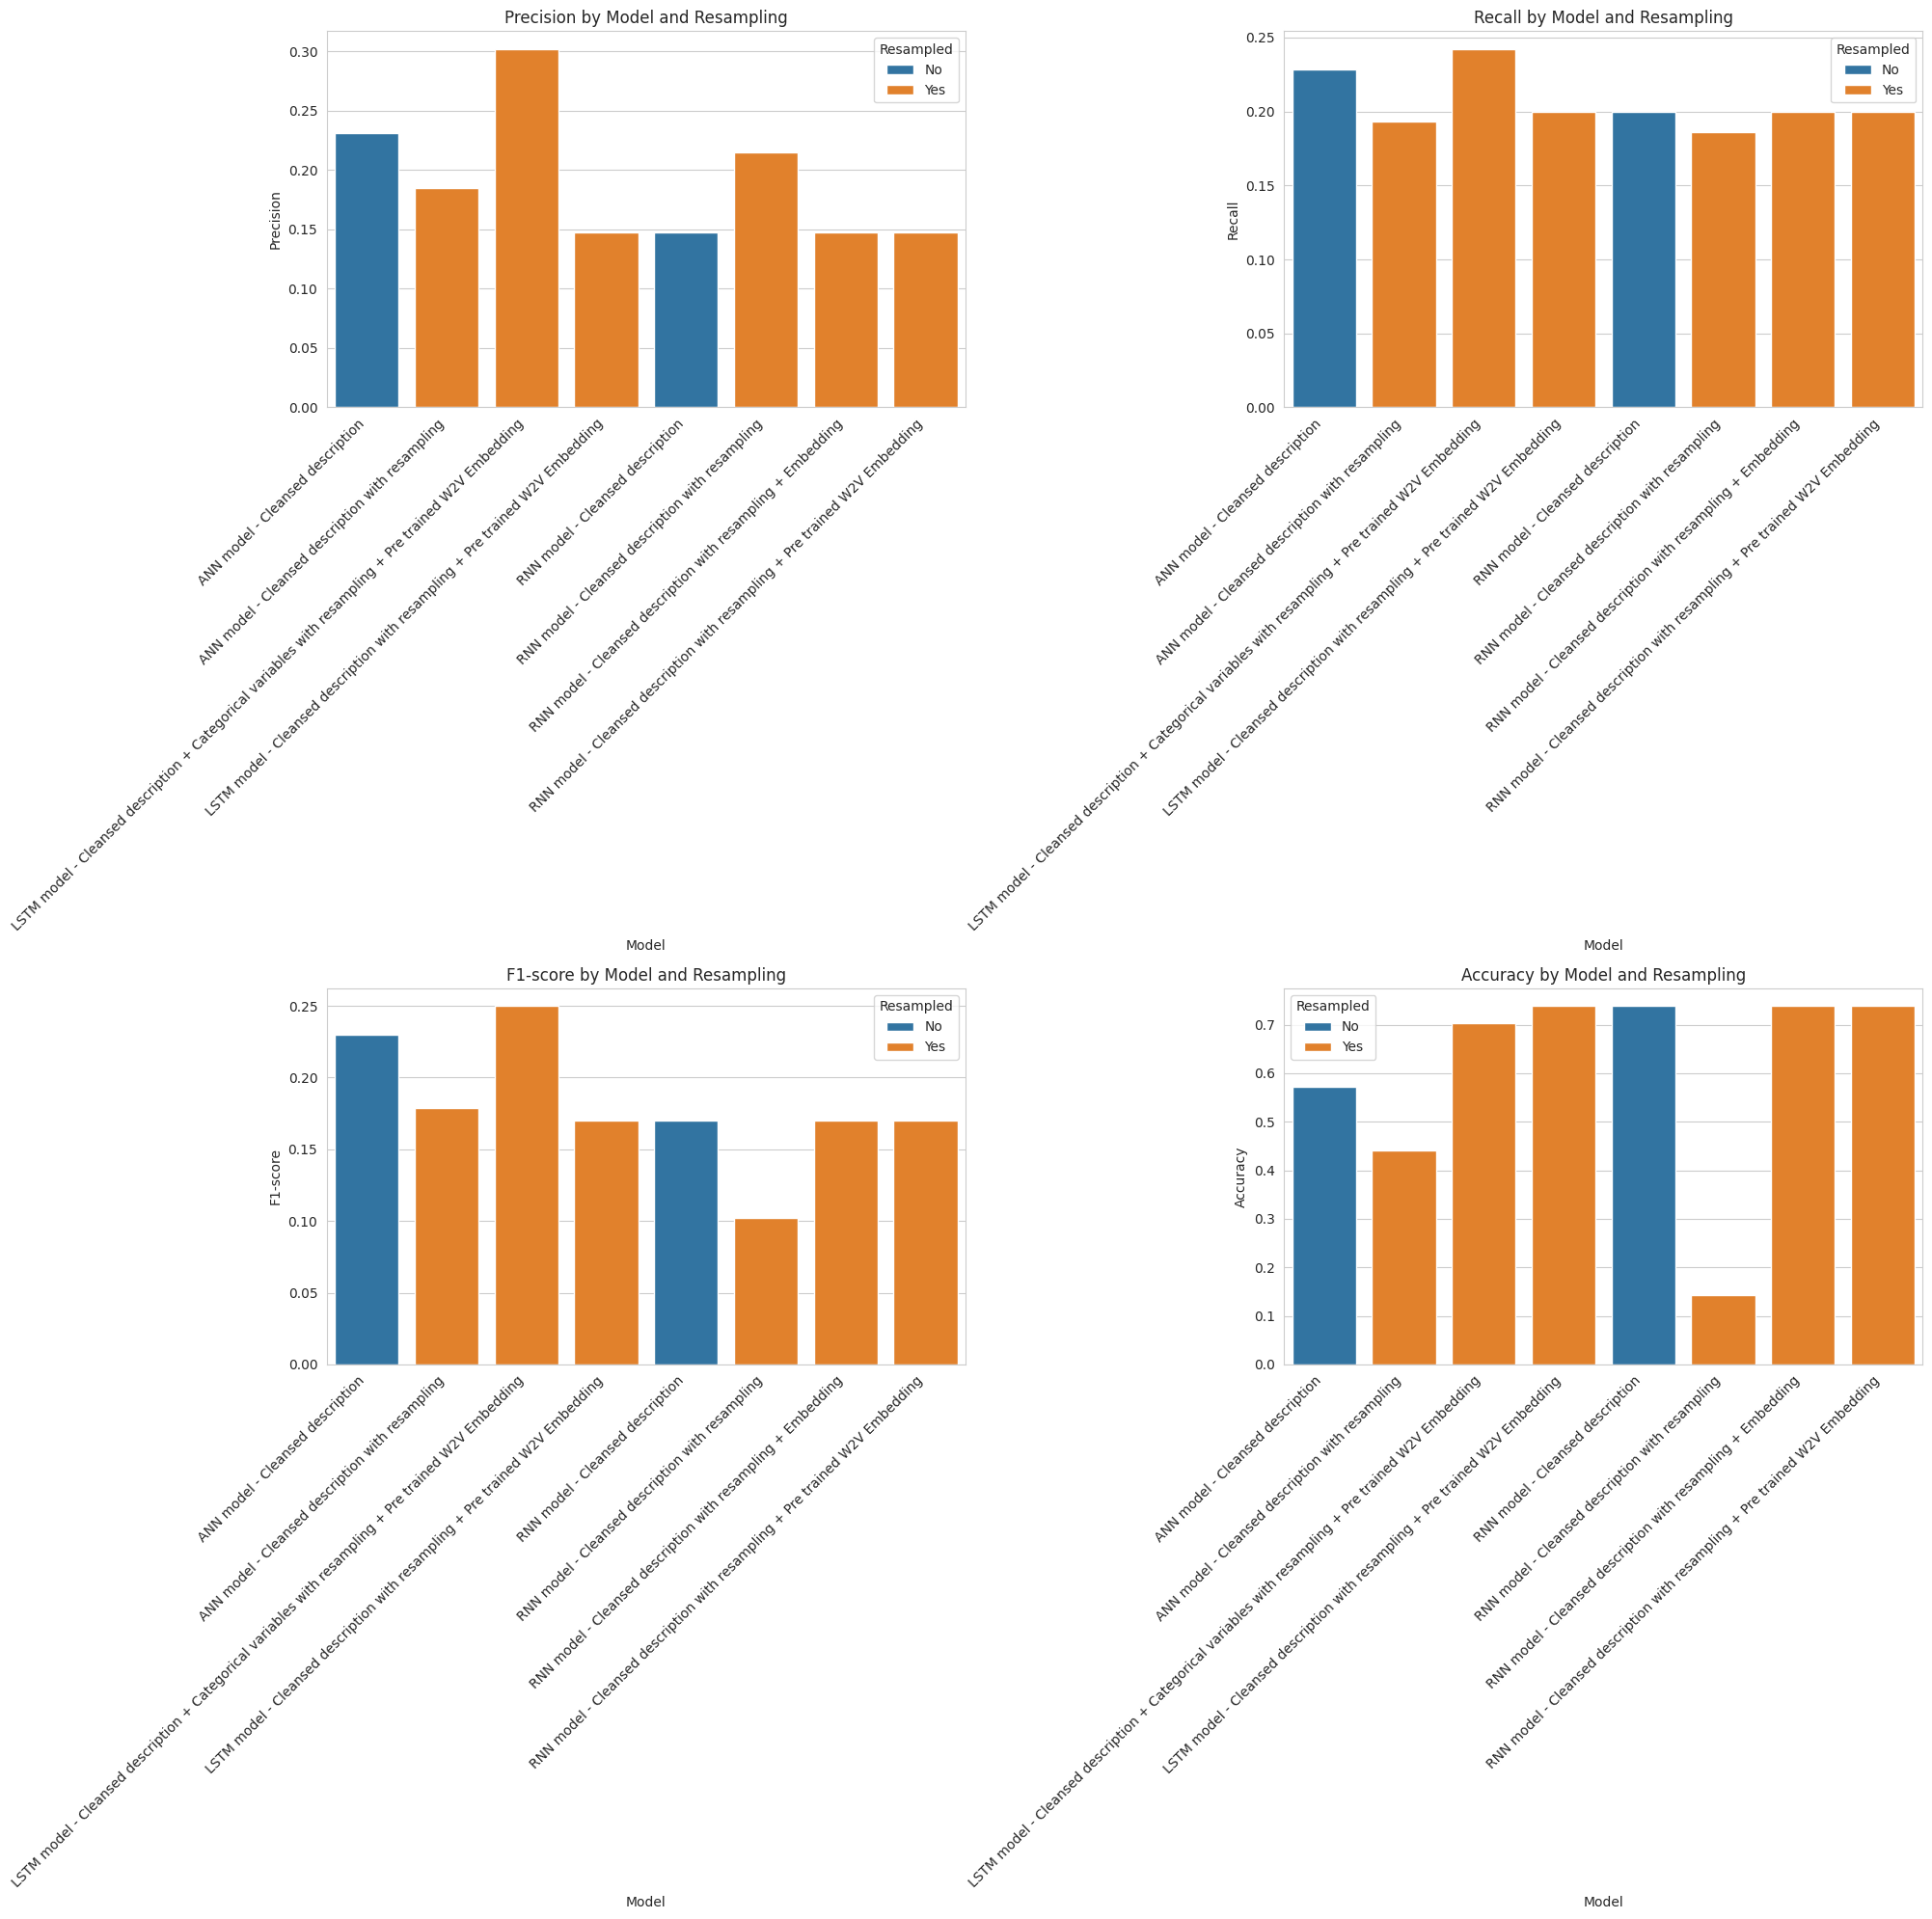

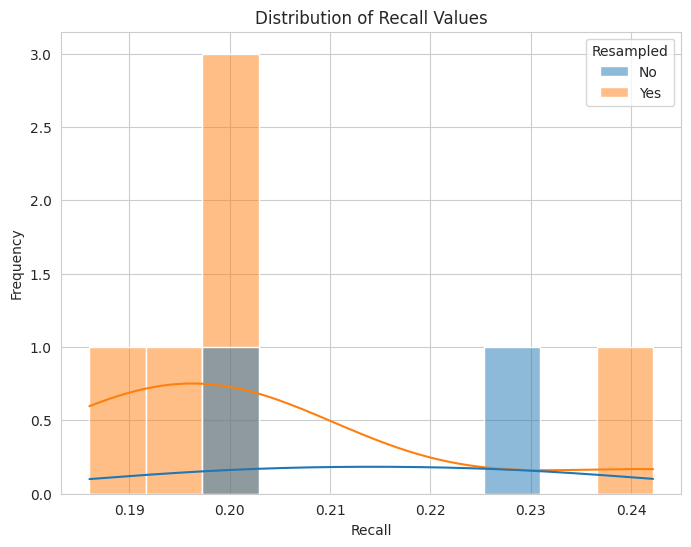

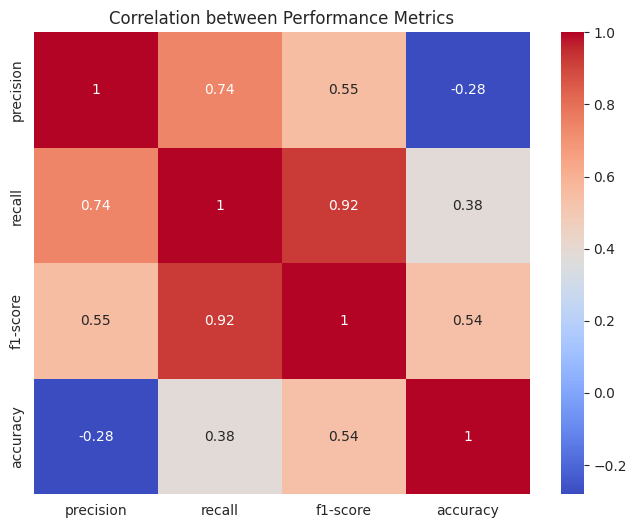

In [131]:
sns.set_style("whitegrid")

grouped_data = stacked_results.groupby(['Model', 'Resampled']).mean().reset_index()

# Visualization 1: Performance Metrics Bar Chart
plt.figure(figsize=(20, 20))
metrics = ['precision', 'recall', 'f1-score', 'accuracy']
for i, metric in enumerate(metrics, 1):
    plt.subplot(2, 2, i)
    sns.barplot(data=grouped_data, x='Model', y=metric, hue='Resampled')
    plt.xticks(rotation=45, ha="right")
    plt.title(f'{metric.capitalize()} by Model and Resampling')
    plt.ylabel(metric.capitalize())
    plt.xlabel('Model')

plt.tight_layout()
plt.show()

# Visualization 2: Recall Distribution
plt.figure(figsize=(8, 6))
sns.histplot(data=grouped_data, x='recall', bins=10, kde=True, hue='Resampled')
plt.title('Distribution of Recall Values')
plt.xlabel('Recall')
plt.ylabel('Frequency')
plt.show()

# Visualization 3: Correlation Heatmap of Performance Metrics
plt.figure(figsize=(8, 6))
corr = grouped_data[metrics].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation between Performance Metrics')
plt.show()


# Pickle the selected model for future use.

In [137]:
import pickle
with open('model.pkl', 'wb') as file:
    pickle.dump(model, file)


# Load the saved model
with open('model.pkl', 'rb') as file:
    loaded_model = pickle.load(file)
